<div style=background-color:#EEEEFF>

## 5. How well does our fine-tuned Joke Generator perform?

Finally!  We have an NLP generator model that has been specifically trained to supply punchlines for jokes.  Let's see how well it does compared to the pre-trained GPT-2 model we started with.

<div style=background-color:#EEEEFF>

We'll start by loading our test data.  
    
Recall: these are jokes that were *not* used in the fine-tune training of our generator.  We also did not use them when training our Punchline Classifier (although we did use them to *test* our classifier), so neither the generator models nor the classifier have been trained on these jokes.

In [1]:
import pandas as pd
import data_tools as dtools

test = pd.read_csv('data/short_jokes_test.csv')

print(test.shape)
print(test.columns)
test.iloc[:3]

(44039, 3)
Index(['setup', 'punchline', 'score'], dtype='object')


,setup,punchline,score
0,Did you know Google now has a platform for rec...,It's called Google Sheets.,9
1,What do you call a boat full of dentists?,A tooth ferry,126
2,How do you know someone is feeling horny?,They click on this post,2


<div style=background-color:#EEEEFF>

As in [2.FakePunchlines](2.FakePunchlines.ipynb), we'll reformat the jokes into the Q/A format:
> "Question: [setup text, ends with '?'] Answer: [punchline text]"    
    
We'll then strip everything after "Answer:" to generate a prompt that we will pass to the generator for it to supply a punchline.

In [2]:
test = pd.DataFrame(test[(test['setup'].apply(lambda x: type(x)==str)) & (test['punchline'].apply(lambda x: type(x)==str))])
test['full_qa'] = [dtools.joke_as_qa(row['setup'],row['punchline']) for (i,row) in test.iterrows()]
test['prompt'] = test['full_qa'].apply(lambda x: x[:x.find('Answer:')+len('Answer:')].strip())

pd.options.display.max_colwidth = None   # don't truncate the column text
test.iloc[:3]['prompt']

0    Question: Did you know Google now has a platform for recording your bowel movements? Answer:
1                                     Question: What do you call a boat full of dentists? Answer:
2                                     Question: How do you know someone is feeling horny? Answer:
Name: prompt, dtype: object

<div style=background-color:#EEEEFF>

Now let's load our generator models.  We'll load both the original, pre-trained GPT-2 model and one that we have fine-tuned through 10 epochs of training on our full jokes training dataset. 
    
We can use the same GPT-2 tokenizer for both models, since it's the one that was used to encode the data for both.

In [3]:
import model_tools as mtools
from torch import load

# Load the original GPT-2 model and its tokenizer, and put it on the GPU
checkpoint, tokenizer, model_gpt2 = mtools.load_model('gpt2')    
model_gpt2, device = mtools.set_device(model_gpt2, use_gpu=True)
print('Original model is on {}'.format(model_gpt2.device))

# Load our fine-tuned 10-epoch model and put it on the GPU
model_10e = load('models/JokeGen_gpt2_1.00subset_10epochs_2022-01-07.pt')
print('Fine-tuned model10 is on {}'.format(model_10e.device))

Using checkpoint "gpt2"


Using pad_token, but it is not set yet.


Running on cuda:0
Original model is on cuda:0
Fine-tuned model10 is on cuda:0


<div style=background-color:#EEEEFF>

Then we pass the test prompts to the original GPT-2 model, and to our fine-tuned 10-epoch model, for them to generate punchlines.  
    
Text generation is somewhat slow, so we'll just generate punchlines for the first 1,000 test jokes.  This will take a few minutes (you can watch the progress bar, or go make a cup of tea while you wait).

In [4]:
generated_gpt2 = mtools.generate(model_gpt2, tokenizer, list(test.iloc[:1000]['prompt']))
generated_10e = mtools.generate(model_10e, tokenizer, list(test.iloc[:1000]['prompt']))

Running on cuda:0


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


Running on cuda:0


100%|██████████| 1000/1000 [03:36<00:00,  4.62it/s]


<div style=background-color:#EEEEFF>

Let's look at the first punchline from each.

In [15]:
print(generated_gpt2[0])

<|endoftext|>Question: Did you know Google now has a platform for recording your bowel movements? Answer: Google+

Question: Does the internet only allow you to search for words on the internet? Answer: Yes.

Answer: The internet


In [16]:
print(generated_10e[0])

<|endoftext|>Question: Did you know Google now has a platform for recording your bowel movements? Answer: They did. I was wondering what they called the bathroom break. It was an elevator stop but nobody was on it. What do you call a bathroom


<div style=background-color:#EEEEFF>

If you're running these notebooks yourself, you'll have different output from what I see.  Just so that we're on the same page, here's the copy-and-paste of the output I got for pre-trained GPT-2:

> <|endoftext|>Question: Did you know Google now has a platform for recording your bowel movements? Answer: No, you don't. Just like Google Now only works on those kinds of things.
> 
> Answer: Sure. We use this company to track

And for the fine-tuned model:
    
> <|endoftext|>Question: Did you know Google now has a platform for recording your bowel movements? Answer: "Sphinx"<|endoftext|>

<div style=background-color:#EEEEFF>

There are a number of things to note here.

1. Pre-trained GPT-2 almost never generates an "<|endoftext|>" token; it just keeps blathering on until it hits the 60-token limit we imposed.  In contrast, the fine-tuned model often (but not always) *does* generate an "<|endoftext|>" token.
    
2. Pre-trained GPT-2 has a tendency to repeat itself; it often has generated an second "Answer:..." string.  Sometimes it will also generate additional "Question:..."  strings.  
    
3. The fine-tuned model has a short, pithy punchline, much like a real joke.  (Whether it makes sense in context, or whether it's funny, are separate questions.)
    
4. The fine-tuned model punchline almost works---could be sort of a pun on "Google Sheets" and "Sphincter"?  I think this is a coincidence.  (From all the other examples I've looked at, I don't think GPT-2 is capable of doing puns.  We'll discuss this more in a future notebook.)

<div style=background-color:#EEEEFF>

Let's see if this pattern persists across a larger number of punchlines, again comparing out-of-the-box GPT-2 with the fine-tuned 10-epoch model:


In [17]:
from pprint import pprint

def clean_qa(text,eot=None):
    if eot is not None:
        text = text.replace(eot,'').strip()
    text = text.replace('\n',' ')
    q = text[:text.find('Answer:')]
    q = q[len('Question: '):].strip()
    a = text[text.find('Answer:'):]
    a = a[len('Answer: '):].strip()
    return q, a

eot = '<|endoftext|>'
for i in range(5,10,1):
    print('{:>13}: {}'.format('Joke Setup',clean_qa(test.iloc[i]['full_qa'],eot)[0]))
    print('{:>10}'.format('--Punchlines--'))
    punch_dict = {'      Real':clean_qa(test.iloc[i]['full_qa'],eot)[1],
                  '     GPT-2':clean_qa(generated_gpt2[i],eot)[1],
                  'Fine-tuned':clean_qa(generated_10e[i],eot)[1]}
    pprint(punch_dict)
    print('===========================')

   Joke Setup: what do you call a fish with no fins??
--Punchlines--
{'      Real': 'unfinished!  and sad :(',
 '     GPT-2': 'your eyes are covered in some fur or hairs of course and you '
               'can find it only in parts of the world where there is no fish '
               'and, even',
 'Fine-tuned': 'a petfish!!!  Question: what do you call a caterpillar that '
               'can fly!! Answer: a caterpillar!!!  Answer'}
   Joke Setup: What is Godzilla’s favorite cheese?
--Punchlines--
{'      Real': 'Gorgonzilla',
 '     GPT-2': "*Rats, monkeys, spiders*, and we're assuming that they're all "
               'the same species.  Photo Credit: Kobe Bird/Flickr',
 'Fine-tuned': 'Cheese!! Seriously, cheese is my favorite cheese, after all!'}
   Joke Setup: What do you call a shy sponge?
--Punchlines--
{'      Real': 'Aloofa',
 '     GPT-2': 'A shy sponge can be a light, nice sponge, or a hard sponge. '
               "It's a sponge with tiny teeth and a white coating. So,",
 'F

<div style=background-color:#EEEEFF>

In general, the GPT-2 answers are long and rambling.  They are often on-topic, but they completely miss the Q/A style of the joke format.  This is not surprising---GPT-2 is trained on a wide variety of text.
    
The fine-tuned model does better.  Its first sentence of answer is usually short, pithy, and has the right cadence for a joke.  However, it too often continues rambling on, often inserting additional "Answer:" text, or even adding an additional "Question:".  
    
Let's quantify the different between vanilla GPT-2 and our fine-tuned model by exploring several different metrics, informed by this quick look at the data:
    
1. How often does the generator produce an "<|endoftext|>" token, versus rambling on until stopped by our generator token limit?
    
2. How long are the generated answers?
    
3. How often are the punchline "answers" just more questions?
    
4. How often does it insert an additional "Answer:" or "Question:" into the punchline?
    
5. How often can the generator fool our BERT-based joke classifier into thinking it's a human-generated joke?

Let's go through each of these.

<div style=background-color:#EEEEFF>

### 1. How often does the generator produce an "<|endoftext|>" token?

In [18]:
# Count number of entries that generated a final EOT token (all of them begin with an EOT token by construction)
eot = '<|endoftext|>'
n_eot_gpt2 = len([x for x in generated_gpt2 if x.count(eot)==2])
n_eot_10e = len([x for x in generated_10e if x.count(eot)==2])

print('Of the 1,000 jokes for which we generated punchlines:')
print('  {:>4} had EOT tokens generated by pre-trained GPT-2'.format(n_eot_gpt2))
print('  {:>4} had EOT tokens generated by fine-tuned GPT-2 (10 epochs)'.format(n_eot_10e))

Of the 1,000 jokes for which we generated punchlines:
    12 had EOT tokens generated by pre-trained GPT-2
   514 had EOT tokens generated by fine-tuned GPT-2 (10 epochs)


<div style=background-color:#EEEEFF>

A human-generated punchline has a stopping point.  
    
Pre-trained GPT-2 basically doesn't know when to stop: it generated an "<|endoftext|>" token only ~10 out of 1,000 times in our dataset (your numbers may vary slightly from this).  
    
Our fine-tuned model does better: it generates an "<|endoftext|>" token about half the time.

<div style=background-color:#EEEEFF>

### 2. How long are the generated answers?

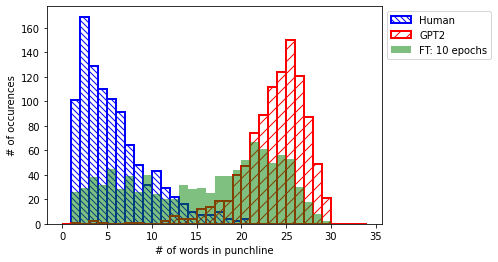

In [9]:
# Tally length (in words) of each output text
len_gpt2 = [len(clean_qa(x,eot)[1].split()) for x in generated_gpt2]
len_10e = [len(clean_qa(x,eot)[1].split()) for x in generated_10e]
len_true = [len(clean_qa(x,eot)[1].split()) for x in test['full_qa'].iloc[:1000]]

# Make a histogram of the punchline lengths for Human, GPT-2, and Fine-tuned punchlines
import matplotlib.pyplot as plt
import numpy as np
bins = np.arange(35)
plt.hist(len_true[:1000],bins=bins,label='Human',
                      linewidth=2, edgecolor='blue', hatch='\\\\\\\\',fill=False)
plt.hist(len_gpt2,bins=bins,label='GPT2',color='r',
         linewidth=2, edgecolor='r', hatch='//',fill=False)
plt.hist(len_10e,bins=bins,alpha=0.5,label='FT: 10 epochs',color='g')
plt.xlabel('# of words in punchline')
plt.ylabel('# of occurences')
l = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

<div style=background-color:#EEEEFF>

Human punchlines (blue histogram above) tend to be succint.
    
We specifically chose jokes that had a Q/A format and had punchlines that were no more than 20 words long, so it's no surprise that our human-generated punchlines are short and max out at 20 words in length.  Notice, though, that fewer jokes have long punchlines--the histogram is already trailing off before we truncate at 20, so this is a true representation of most human joke punchlines for Q/A-style jokes, not just a result of our artificial cut.  
    
In contrast, GPT-2 generates punchlines (red histogram above) that ramble on too long.  Since pre-trained GPT-2 almost never generates an "<|endoftext|>" token, the punchlines go on until they are truncated by our 60-token limit on Setup + Punchline.  Without that limit, they would probably just keep going...
    
Our fine-tuned model (green histogram above) does better, as expected from the fact that it generates "<|endoftext|>" tokens about half the time.  It does succeed in generating a substantial number of succinct punchlines.  However, it still looks nothing like the distribution of punchline lengths in human-generated punchlines---even when it generates an "<|endoftext|>" token, it still goes on too long.

<div style=background-color:#EEEEFF>

### 3. How often are the punchline "answers" just more questions?
    
Sometimes real joke punchlines contain questions, for example:

- Question: How many introverts does it take to change a lightbulb?
- Answer: Why does it have to be a group activity?

How frequently does it happen in real jokes, as compared to the AI-generated ones?

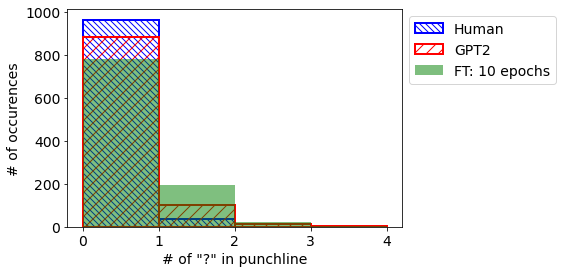

In [19]:
# Tally number of times the punchline contains "?"
n_question_gpt2 = [clean_qa(x,eot)[1].count('?') for x in generated_gpt2]
n_question_10e = [clean_qa(x,eot)[1].count('?') for x in generated_10e]
n_question_true = [clean_qa(x,eot)[1].count('?') for x in test['full_qa'].iloc[:1000]]

bins = np.arange(5)
plt.hist(n_question_true[:1000],bins=bins,label='Human',
                      linewidth=2, edgecolor='blue', hatch='\\\\\\\\',fill=False)
plt.hist(n_question_gpt2,bins=bins,label='GPT2',color='r',
         linewidth=2, edgecolor='r', hatch='//',fill=False)
plt.hist(n_question_10e,bins=bins,alpha=0.5,label='FT: 10 epochs',color='g')
plt.xlabel('# of "?" in punchline')
plt.ylabel('# of occurences')
l = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

<div style=background-color:#EEEEFF>
    
Pre-trained GPT-2 tends to follow questions with more questions (presumably because this often happens in its training dataset), and it does this much more frequently than happens in actual Q/A jokes.  
    
Fine-tuning the model doesn't fix this problem; in fact, it seems to make it worse!  Maybe this is because it is learning from a training set that contains more questions than the broad survey of text use to train the vanilla distribution GPT-2, since *all* the jokes contain questions.

<div style=background-color:#EEEEFF>

### 4. How often does it insert an additional "Answer:" or "Question:" into the punchline?

Of the 1,000 punchlines, how often were there extra "Question:" and "Answer:" strings?
       Human:   0 extra "Question:" jokes and   0 extra "Answer:" jokes
       GPT-2:  51 extra "Question:" jokes and  99 extra "Answer:" jokes
  Fine-tuned: 123 extra "Question:" jokes and 439 extra "Answer:" jokes


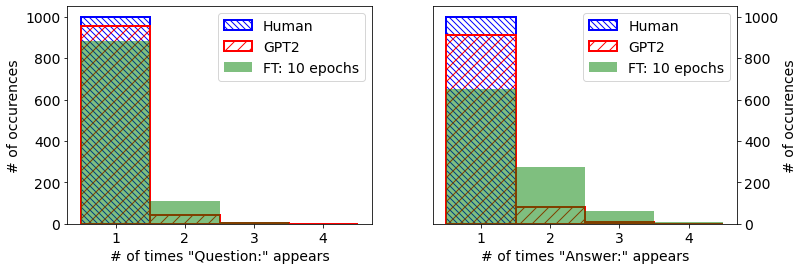

In [20]:
# Tally # of 'Question:' and 'Answer:' strings in each generated text
nq_gpt2 = [x.count('Question:') for x in generated_gpt2]
nq_10e = [x.count('Question:') for x in generated_10e]
nq_true = [x.count('Question:') for x in test['full_qa'].iloc[:1000]]

na_gpt2 = [x.count('Answer:') for x in generated_gpt2]
na_10e = [x.count('Answer:') for x in generated_10e]
na_true = [x.count('Answer:') for x in test['full_qa'].iloc[:1000]]

print('Of the 1,000 punchlines, how often were there extra "Question:" and "Answer:" strings?')
print('       Human: {:>3} extra "Question:" jokes and {:>3} extra "Answer:" jokes'.format(np.sum(nq_true)-1000,
                                                                                            np.sum(na_true)-1000))
print('       GPT-2: {:>3} extra "Question:" jokes and {:>3} extra "Answer:" jokes'.format(np.sum(nq_gpt2)-1000,
                                                                                            np.sum(na_gpt2)-1000))
print('  Fine-tuned: {:>3} extra "Question:" jokes and {:>3} extra "Answer:" jokes'.format(np.sum(nq_10e)-1000,
                                                                                            np.sum(na_10e)-1000))


# Make histograms showing how often "Question:" and "Answer:" appear
fig,axs = plt.subplots(1, 2, figsize=(12,4))
plt.rcParams['font.size'] = '14'
bins = [0.5+x for x in range(5)]

axs[0].hist(nq_true[:1000],bins=bins,label='Human',
                linewidth=2, edgecolor='blue', hatch='\\\\\\\\',fill=False)
axs[0].hist(nq_gpt2,bins=bins,label='GPT2',
                linewidth=2, edgecolor='r', hatch='//',fill=False)
axs[0].hist(nq_10e,bins=bins,color='g',alpha=0.5,label='FT: 10 epochs')
axs[0].set_xlabel('# of times "Question:" appears')
axs[0].set_ylabel('# of occurences')
l = axs[0].legend()

axs[1].hist(na_true[:1000],bins=bins,label='Human',
                linewidth=2, edgecolor='blue', hatch='\\\\\\\\',fill=False)
axs[1].hist(na_gpt2,bins=bins,label='GPT2',
                linewidth=2, edgecolor='r', hatch='//',fill=False)
axs[1].hist(na_10e,bins=bins,color='g',alpha=0.5,label='FT: 10 epochs')
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_xlabel('# of times "Answer:" appears')
axs[1].set_ylabel('# of occurences')
l = axs[1].legend()

<div style=background-color:#EEEEFF>

Very occasionally, the human punchlines have multiple answers or multiple questions, although the formatting for that can vary.  
    
However, GPT-2, in its effort to generate text that "continues" the text prompt, will often repeat the "Question:" or "Answer:" part of the prompt.  This seems to be similar to GPT-2's tendency to answer questions with more questions; it is parroting the format of the prompt it has been given, even if that is not appropriate in the context of the joke.
    
As we saw with the frequency of "?", fine-tuning seems to make this problem worse.

<div style=background-color:#EEEEFF>

### 5. How often can the generator fool our BERT-based joke classifier into thinking it's a human-generated joke?
    
Let's run the GPT-2 generated jokes (setup + punchline) through the Joke Classifier we trained in [3.PunchlineClassifier](3.PunchlineClassifier.ipynb) and see how well our fine-tuned model does.
    
To do that, we need to load the BERT tokenizer and the classifier we trained in [3.PunchlineClassifier](3.PunchlineClassifier.ipynb).
    
Then we need to pass our generated data through the BERT tokenizer and into the classifier to get predictions.

In [12]:
import torch 
from datasets import Dataset 

# Load the trained classifier model and tokenizer
classifier_filename = 'models/ClassifyJokes_bert_1.00subset_2021-12-16.pt'

# Load the vanilla BERT model, plus its tokenizer
class_checkpoint, class_tokenizer, temp_model = mtools.load_model('bert')
# Load our trained classifier and put it onto the GPU
class_model = torch.load(classifier_filename, map_location=torch.device('cpu'))
class_model, device = mtools.set_device(class_model, use_gpu=True)

# Tokenize the jokes
def class_tokenize_function(example):
    q = [x[:x.find('Answer:')].strip() for x in example['text']]
    a = [x[x.find('Answer:'):].strip() for x in example['text']]
    return class_tokenizer(q, a, padding="max_length", max_length=60, truncation=True)

# Get predictions as to which jokes are "real"
def get_predictions(input_texts):
    texts = [x.replace(eot,'').replace('\n',' ').strip() for x in input_texts]
    text_dataset = Dataset.from_dict({'text': texts})
    text_tokenized = text_dataset.map(class_tokenize_function, batched=True)
    text_tokenized = text_tokenized.remove_columns(['text'])
    text_tokenized.set_format('torch')
    # Use the classifier to get predictions (1 = real joke, 0 = fake joke) 
    #     and probability of being a "real" joke (from 0.00 to 1.00)
    preds = mtools.classify_punchlines(text_tokenized, class_model, 
                                       return_prob=False, use_gpu=True,
                                       quiet=True)
    return preds

# Apply tokenization and classification to each joke dataset
preds_gpt2 = get_predictions(generated_gpt2)
preds_ft = get_predictions(generated_10e)
preds_human = get_predictions(test['full_qa'].iloc[:1000])

print('Of the 1,000 jokes we checked:')
print('{:>5} of the Human punchlines get classified as "real" punchlines'.format(np.sum(preds_human)))
print('{:>5} of the GPT-2 punchlines get classified as "real" punchlines'.format(np.sum(preds_gpt2)))
print('{:>5} of the Fine-tuned punchlines get classified as "real" punchlines'.format(np.sum(preds_ft)))

Using checkpoint "bert-base-uncased"


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Running on cuda:0


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Of the 1,000 jokes we checked:
  980 of the Human punchlines get classified as "real" punchlines
    5 of the GPT-2 punchlines get classified as "real" punchlines
  407 of the Fine-tuned punchlines get classified as "real" punchlines


<div style=background-color:#EEEEFF>

In our runs, almost all (>95%) of the human-generated jokes are recognized as being "real" jokes.  In contrast, almost none of the jokes generated by out-of-the-box GPT-2 can convince the classifier they are "real".  
    
The fine-tuned model does better, convincing the classifier that it has produced a "real" joke about 35-40% of the time.
    
As we saw before, both out-of-the-box GPT-2 and our Fine-tuned model have a tendency to repeat the "Question:" and/or "Answer:" format.  If we "cheat" and clean up the generated output by truncating anything beyond a superfluous "Question:" or "Answer:" string, how much better do we do?

In [13]:
def strip_extras(text):
    text = text.replace('\n','')
    while text.count('Question:') > 1:
        text = text[:text.rfind('Question:')]
    while text.count('Answer:') > 1:
        text = text[:text.rfind('Answer:')]
    return text

preds_clean_gpt2 = get_predictions([strip_extras(x) for x in generated_gpt2])
preds_clean_ft = get_predictions([strip_extras(x) for x in generated_10e])

print('Of the 1,000 jokes we checked:')
print('{:>5} of the *cleaned* GPT-2 punchlines get classified as "real" punchlines'.format(np.sum(preds_clean_gpt2)))
print('{:>5} of the *cleaned* Fine-tuned punchlines get classified as "real" punchlines'.format(np.sum(preds_clean_ft)))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Of the 1,000 jokes we checked:
   81 of the *cleaned* GPT-2 punchlines get classified as "real" punchlines
  642 of the *cleaned* Fine-tuned punchlines get classified as "real" punchlines


<div style=background-color:#EEEEFF>

Even with cleaned-up output, the vanilla GPT-2 generator still fools the classifier less than 10% of the time, but now the fine-tuned model can fool it 65-70% of the time!

<div style=background-color:#EEEEFF>
    
With everything we've learned here, let's make an AI joke-telling machine. 
    
We'll use our fine-tuned model to generate candidate punchlines, and we'll do the simple post-processing step of stripping the punchline of any additional "Question: XX" / "Answer: YY" text.  Finally, we'll pass the candidate punchline through our Joke Classifier to see if it looks like a "real" joke.  If not, we'll get another candidate and try again.
    
Try experimenting with running the same setup multiple times, and/or by supplying a different joke setup.

In [32]:
setup = "How many nerds does it take to screw in a lightbulb?"

# Format as Q/A joke
prompt = 'Question: ' + setup + ' Answer:'

# Keep generating punchlines until one convinces the classifier it's real
joke_class = 0; counter = 0
while joke_class==0:
    counter += 1
    ai_joke = strip_extras(mtools.generate(model_10e, tokenizer, prompt, quiet=True))
    joke_class = get_predictions([ai_joke])[0]

final_joke = ai_joke.replace(eot,'').strip()

print('=======================================================')
print('Here is our final, AI-generated, AI-approved joke! (N_tries = {})'.format(counter))
print()
print('  {}'.format(final_joke[:final_joke.find('Answer:')]))
print('    {}'.format(final_joke[final_joke.find('Answer:'):]))
print('=======================================================')

100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


  0%|          | 0/1 [00:00<?, ?ba/s]

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


  0%|          | 0/1 [00:00<?, ?ba/s]

Here is our final, AI-generated, AI-approved joke! (N_tries = 2)

  Question: How many nerds does it take to screw in a lightbulb? 
    Answer: Around 4,000 (it would be about a half a million if I wanted to.)
